# Generate ML data using MOM6

# Masking can be improved. 

### Setup dask

In [1]:
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))

flag_shut = False 

if flag_shut: 
    if len(open_clusters)>0:
        for c in open_clusters:
            cluster = gateway.connect(c.name)
            cluster.shutdown()  

options = gateway.cluster_options()

#options.worker_memory = 16 # 24 works fine for long term mean, but seasonal needs a bit more
# options.worker_cores = 8

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.adapt(15, 40)
#cluster.scale(10)
client

[]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.654663663a4b4b8f993bdeb5ddf8f295/status,


In [2]:
# If wanting to look at local server.
#import dask
#import distributed

#client = distributed.Client()
#client

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter
import gcm_filters as gcmf

import warnings
warnings.filterwarnings('ignore')

In [4]:
from dask.diagnostics import ProgressBar

In [5]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [6]:
import gcsfs
fs = gcsfs.GCSFileSystem()
fs.ls(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/')

['leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_100km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_200km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_400km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_50km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge300day',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge60day']

In [7]:
#fs.rm(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_50km.zarr', recursive=True)

In [8]:
#ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day/prog.zarr')
#ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge60day/prog.zarr')
#ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge300day/prog.zarr')

ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day_long.zarr')

In [9]:
#ds = ds.chunk({'Time':1,'xh':-1,'yh':-1,'xq':-1,'yq':-1})
ds

<xarray.Dataset>
Dimensions:  (Time: 7200, zl: 2, yq: 401, xq: 301, zi: 3, yh: 400, xh: 300)
Coordinates:
  * Time     (Time) object 0001-01-11 00:00:00 ... 0198-02-16 00:00:00
  * xh       (xh) float64 2.0 6.0 10.0 14.0 ... 1.19e+03 1.194e+03 1.198e+03
  * xq       (xq) float64 0.0 4.0 8.0 12.0 ... 1.192e+03 1.196e+03 1.2e+03
  * yh       (yh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yq       (yq) float64 0.0 4.0 8.0 12.0 ... 1.592e+03 1.596e+03 1.6e+03
  * zi       (zi) float64 1.03e+03 1.032e+03 1.034e+03
  * zl       (zl) float64 1.031e+03 1.033e+03
Data variables:
    PV       (Time, zl, yq, xq) float32 dask.array<chunksize=(72, 2, 401, 301), meta=np.ndarray>
    RV       (Time, zl, yq, xq) float32 dask.array<chunksize=(72, 2, 401, 301), meta=np.ndarray>
    e        (Time, zi, yh, xh) float32 dask.array<chunksize=(72, 3, 400, 300), meta=np.ndarray>
    h        (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 400, 300), meta=np.ndarray>
    u        (Time, zl, yh, xq) float32 dask.array<chunksize=(72, 2, 400, 301), meta=np.ndarray>
    v        (Time, zl, yq, xh) float32 dask.array<chunksize=(72, 2, 401, 300), meta=np.ndarray>
Attributes:
    filename:   prog__00010.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      Phillips experiment

In [27]:
Lfilter = np.array([100e3])
dx = 4e3 
coarsen_factor = 5 
coarsen_points= (Lfilter/coarsen_factor/dx).astype('int')

In [33]:
def filter_dataset(ds, Lfilter): 
    
    dx = ds.xh.diff('xh')[0].values*1e3
    #wet_mask= (ds.h.isel(Time=0, zl=0)*0. + 1.).rename('wet_mask')
    #wet_mask_w_land = wet_mask
    wet_mask = (ds.h.isel(Time=0, zl=1)>1).astype('float32').rename('wet_mask')
    wet_mask_w_land = wet_mask.where(ds.yh <1595., other=0)
    
    filter_C = gcmf.Filter(filter_scale= Lfilter,  
                     dx_min = dx, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND,
                     grid_vars = {'wet_mask': wet_mask_w_land})
    
    xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])
    
    ds_filt = xr.Dataset() # For storing the filtered data 
    print('Started')
    ds_filt['h'] = filter_C.apply(ds.h, dims=['yh','xh']).rename('h')
    ds_filt['e'] = filter_C.apply(ds.e, dims=['yh','xh']).rename('e')
    u_c = xgrid.interp(ds.u.fillna(0), 'X')
    v_c = xgrid.interp(ds.v.fillna(0), 'Y')
    ds_filt['u'] = filter_C.apply(u_c, dims=['yh','xh']).rename('u')
    ds_filt['v'] = filter_C.apply(v_c, dims=['yh','xh']).rename('v')
    
    print('Filtered fields computed')
    
    ds_filt['uh'] = ds.h*u_c
    ds_filt['vh'] = ds.h*v_c
    
    ds_filt['uu'] = u_c*u_c
    ds_filt['vv'] = v_c*v_c
    
    ds_filt['uh_bar'] = filter_C.apply(ds_filt['uh'], dims=['yh','xh']).rename('uh_bar')
    ds_filt['vh_bar'] = filter_C.apply(ds_filt['vh'], dims=['yh','xh']).rename('vh_bar')
    
    ds_filt['uu_bar'] = filter_C.apply(ds_filt['uu'], dims=['yh','xh']).rename('uu_bar')
    ds_filt['vv_bar'] = filter_C.apply(ds_filt['vv'], dims=['yh','xh']).rename('vv_bar')
    
    ds_filt['ubar_hbar'] = (ds_filt.h*ds_filt.u)
    ds_filt['vbar_hbar'] = (ds_filt.h*ds_filt.v)
    
    ds_filt['ubar_ubar'] = (ds_filt.u*ds_filt.u)
    ds_filt['vbar_vbar'] = (ds_filt.v*ds_filt.v)
    
    ds_filt['uh_sg'] = ds_filt['uh_bar'] - ds_filt['ubar_hbar']
    ds_filt['vh_sg'] = ds_filt['vh_bar'] - ds_filt['vbar_hbar']
    
    ds_filt['uu_sg'] = ds_filt['uu_bar'] - ds_filt['ubar_ubar']
    ds_filt['vv_sg'] = ds_filt['vv_bar'] - ds_filt['vbar_vbar']
    
    print('Fluxes computed')
    
    ds_filt['dudx'] = xgrid.interp(xgrid.diff(ds_filt.u, 'X')/dx, 'X')
    ds_filt['dvdx'] = xgrid.interp(xgrid.diff(ds_filt.v, 'X')/dx, 'X')
    ds_filt['dudy'] = xgrid.interp(xgrid.diff(ds_filt.u, 'Y')/dx, 'Y')
    ds_filt['dvdy'] = xgrid.interp(xgrid.diff(ds_filt.v, 'Y')/dx, 'Y')
    ds_filt['slope_x'] = xgrid.interp(xgrid.diff(ds_filt.e, 'X')/dx, 'X')
    ds_filt['slope_y'] = xgrid.interp(xgrid.diff(ds_filt.e, 'Y')/dx, 'Y')
    
    print('Gradients computed')
    
    return ds_filt

In [34]:
def coarsen_dataset(ds, coarsen_points): 
    print('coarsening')
    return ds.coarsen(xh=coarsen_points, yh=coarsen_points).mean()

In [35]:
ds_filt_coarsen = coarsen_dataset(filter_dataset(ds, Lfilter[0]), coarsen_points[0]) 

Started
Filtered fields computed
Fluxes computed
Gradients computed
coarsening


In [36]:
temp = ds_filt_coarsen.vh_sg.isel(Time=-1, zl=-1)
temp.load(); 

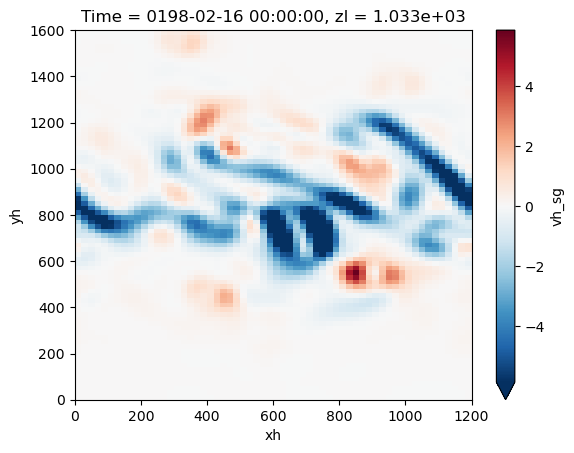

In [37]:
temp.plot(robust=True)

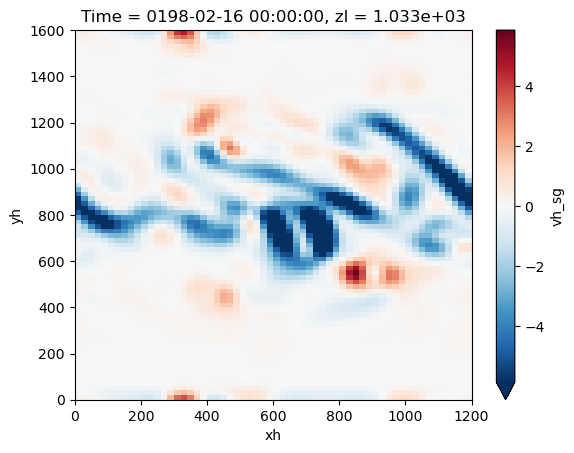

In [32]:
temp.plot(robust=True)

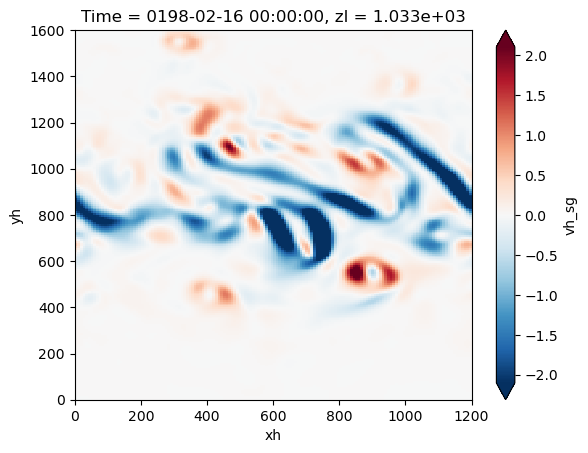

In [22]:
temp.plot(robust=True)

In [49]:
#ds_filt_coarsen_small = ds_filt_coarsen.isel(Time=slice(0, 1440))

In [50]:
#with ProgressBar():
#    ds_filt_coarsen_small.load()

In [51]:
fname = f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_'+str(int(Lfilter/1e3))+'km.zarr'
fname
mapper = fs.get_mapper(fname)

In [52]:
fname

'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_400km.zarr'

In [53]:
def to_zarr_split(ds, mapper, split_dim="time", split_interval=1):
    print(f"Writing to {mapper.root} ...")

    n = len(ds[split_dim])
    splits = list(range(0, n, split_interval))

    # Make sure the last item in the list covers the full length
    # of the time on our dataset
    if splits[-1] != n:
        splits = splits + [n]

    split_datasets = []
    for ii in range(len(splits) - 1):
        start = splits[ii]
        stop = splits[ii + 1]
        split_datasets.append(ds.isel({split_dim: slice(start, stop)}))

    # write the first array
    # TODO: move the first write to the loop so it is counted in the viz bar
    split_datasets[0].to_zarr(mapper)
    for ds_split in tqdm(split_datasets[1:None]):
        ds_split.to_zarr(mapper, append_dim=split_dim)

    # overwrite the split dimension as single chunk (this should reproduce
    # what xr.to_zarr would do
    g = zarr.open_group(mapper)
    del g[split_dim]
    
    ds[[split_dim]].load().to_zarr(mapper, mode='a')
    zarr.consolidate_metadata(mapper)

In [54]:
import zarr
from tqdm.auto import tqdm

In [55]:
%%time 
to_zarr_split(ds_filt_coarsen, mapper, split_dim='Time', split_interval=720)

Writing to leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_400km.zarr ...


  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 17.6 s, sys: 1.77 s, total: 19.4 s
Wall time: 1h 18min 54s


In [ ]:
#fname = f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day/ml_data_'+str(int(Lfilter/1e3))+'km.zarr'
#fname = f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge60day/ml_data_'+str(int(Lfilter/1e3))+'km.zarr'
#fname = f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge300day/ml_data_'+str(int(Lfilter/1e3))+'km.zarr'


In [56]:
fname

'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_400km.zarr'

In [57]:
test = xr.open_zarr(fname)

In [58]:
test

<xarray.Dataset>
Dimensions:    (Time: 7200, zl: 2, yh: 20, xh: 15, zi: 3)
Coordinates:
  * Time       (Time) object 0001-01-11 00:00:00 ... 0198-02-16 00:00:00
  * xh         (xh) float64 40.0 120.0 200.0 280.0 ... 1e+03 1.08e+03 1.16e+03
  * yh         (yh) float64 40.0 120.0 200.0 280.0 ... 1.4e+03 1.48e+03 1.56e+03
  * zi         (zi) float64 1.03e+03 1.032e+03 1.034e+03
  * zl         (zl) float64 1.031e+03 1.033e+03
Data variables: (12/26)
    dudx       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>
    dudy       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>
    dvdx       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>
    dvdy       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>
    e          (Time, zi, yh, xh) float32 dask.array<chunksize=(72, 3, 20, 15), meta=np.ndarray>
    h          (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>
    ...         ...
    vh         (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>
    vh_bar     (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>
    vh_sg      (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>
    vv         (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>
    vv_bar     (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>
    vv_sg      (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 20, 15), meta=np.ndarray>

In [59]:
#fs.ls(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge300day/')

### When done

In [38]:
cluster.shutdown()